In [1]:
%load_ext autoreload
%autoreload 2

import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
from scipy.optimize import minimize_scalar, root_scalar

from diffbank.bank import Bank
from diffbank.metric import get_density
from diffbank.noise import Sn_aLIGO
from diffbank.utils import get_m1_m2_sampler
from diffbank.waveforms.threePN_simple import Psi, amp

Setup

In [2]:
key = random.PRNGKey(90)

minimum_match = 0.95
m_star = 1 - minimum_match
eta_star = 0.99
fs = jnp.linspace(20.0, 2000.0, 1000)
m_range = (1.4, 5.0)
sampler = get_m1_m2_sampler(m_range, m_range)

bank_r = Bank(amp, Psi, fs, Sn_aLIGO, m_star, eta_star, sampler, name="3pn-random")
bank_s = Bank(amp, Psi, fs, Sn_aLIGO, m_star, eta_star, sampler, name="3pn-stochastic")

# Get max density
fun = lambda m1: -bank_r.density_fun(jnp.array([m1, m_range[0]]))
res = minimize_scalar(fun, bracket=m_range, bounds=m_range)
assert res.success
theta_dmax = jnp.array([res.x, m_range[0]])
ratio_max = bank_r.density_fun(theta_dmax)
bank_r.ratio_max = ratio_max
bank_s.ratio_max = ratio_max

Random bank

In [15]:
bank_r.name = "3pn-random-2"

In [16]:
key, subkey = random.split(key)
bank_r.fill_bank(subkey, "random", n_eff=1000)

  0%|          | 0/990 [00:00<?, ?it/s]

In [23]:
key, subkey = random.split(key)
bank_r.calc_bank_effectualness(subkey, 500)

  0%|          | 0/500 [00:00<?, ?it/s]

In [24]:
bank_r.save("banks/")

Stochastic bank

In [7]:
key, subkey = random.split(key)
bank_s.fill_bank(subkey, "stochastic", n_eff=1000)

  0%|          | 0/990 [00:00<?, ?it/s]

In [10]:
bank_s.save("banks/")

In [5]:
bank_s = Bank.load("banks/3pn-stochastic.npz", amp, Psi, Sn_aLIGO, sampler)

In [6]:
key, subkey = random.split(key)
bank_s.calc_bank_effectualness(subkey, 500)

  0%|          | 0/500 [00:00<?, ?it/s]

Compare

/Users/acoogan/.pyenv/versions/3.9.1/envs/tbanks-3.9.1/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6665: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]
/Users/acoogan/.pyenv/versions/3.9.1/envs/tbanks-3.9.1/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6665: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


Text(0.5, 1.0, '3PN')

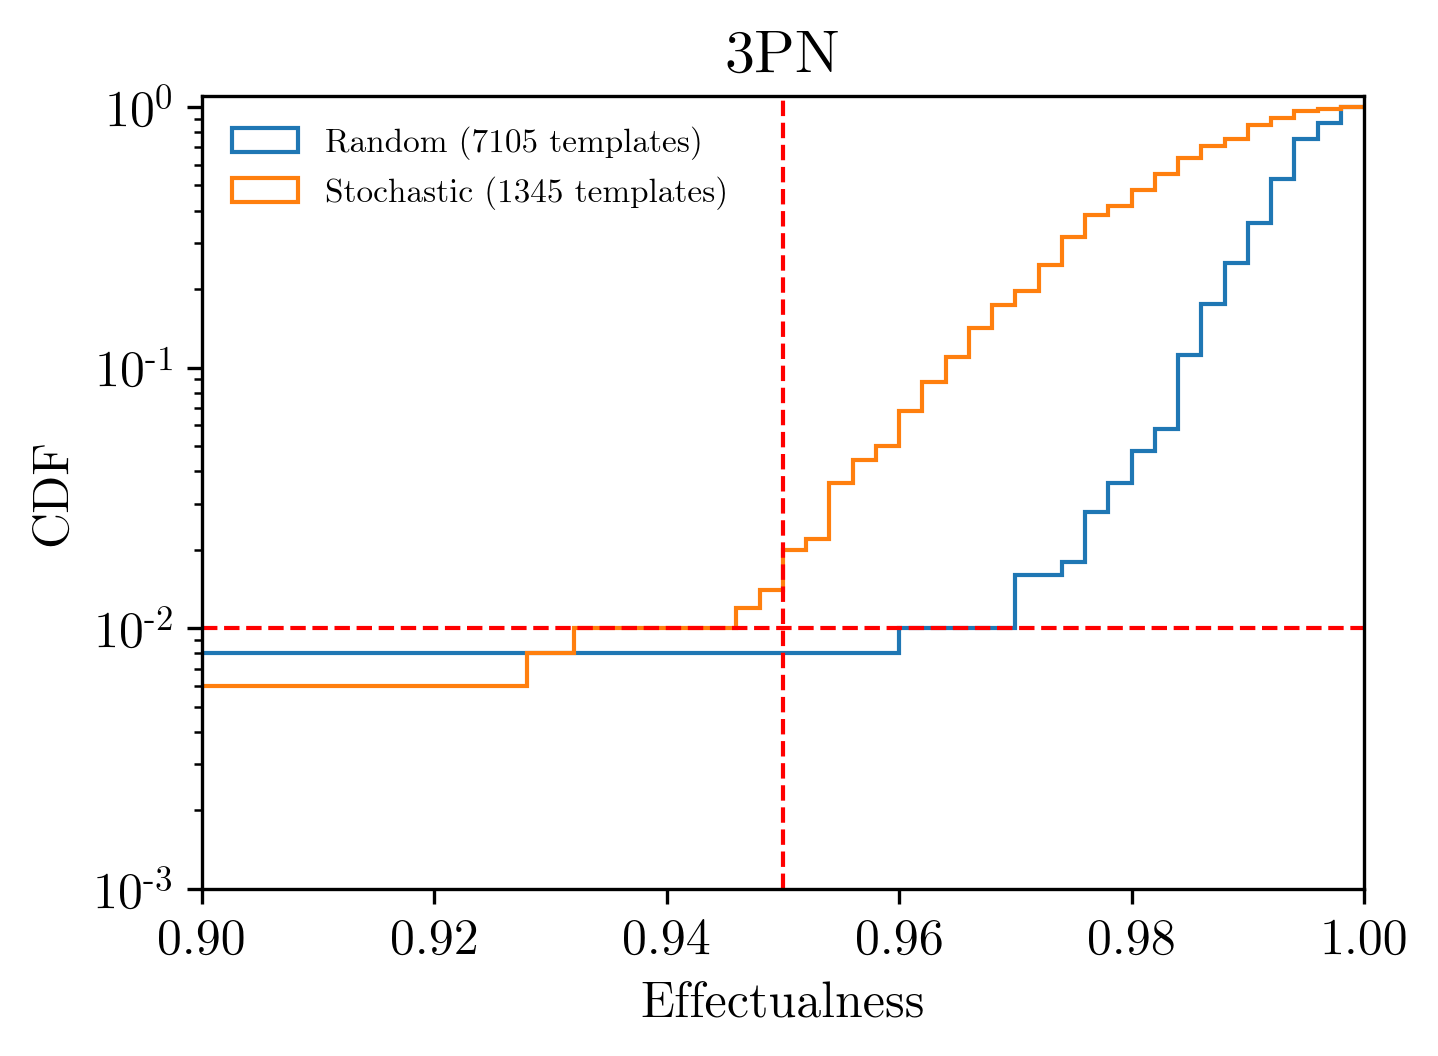

In [20]:
n_eff = len(bank_r.effectualnesses)
bins = jnp.concatenate(
    (jnp.array([0.0]), jnp.linspace(0.9, 1, int(0.1 * n_eff + 1)), jnp.array([jnp.inf]))
)
plt.hist(
    bank_r.effectualnesses,
    bins=bins,
    density=True,
    cumulative=True,
    histtype="step",
    label=f"Random ({bank_r.n_templates} templates)",
)
plt.hist(
    bank_s.effectualnesses,
    bins=bins,
    range=(0, 1),
    density=True,
    cumulative=True,
    histtype="step",
    label=f"Stochastic ({bank_s.n_templates} templates)",
)
plt.axvline(1 - m_star, color="r", linestyle="--", linewidth=1)
plt.axhline(1 - eta_star, color="r", linestyle="--", linewidth=1)
plt.axhline(5)
plt.axhline(4)
plt.legend(loc="upper left", frameon=False, fontsize=8)
plt.xlim(bins[1], 1)
plt.ylim(0.5 / n_eff, 1.1)
plt.yscale("log")
plt.xlabel("Effectualness")
plt.ylabel("CDF")
plt.title("3PN")